# Neural Network Modeling
This notebook contains the logic for neural network regression and classification tasks.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls 

drive  sample_data


In [ ]:
cleaned = pd.read_csv("/content/drive/Shareddrives/Data Science 303 Group Project/csv/cleaned_fires_data_with_four_closest_stations_nov21.csv")
cleaned = cleaned.replace([np.inf, -np.inf], np.nan)
cleaned = cleaned.dropna()

In [ ]:
display(cleaned.head())
display(cleaned.info(verbose=True))

STATION_LIST = ["BODIE", "BROOKS", "COHASSET", "EEL_RIVER", "HELL_HOLE", "HERNANDEZ"]
STATION_LIST += ["HUNTER_MOUNTAIN", "JUANITA_LAKE", "LADDER_BUTTE", "LAS_TABLAS", "LA_HONDA", "OAK_CREEK"]
STATION_LIST += ["PANAMINT", "PILOT_HILL", "SCORPION", "SOLDIER_MOUNTAIN", "SQUAW_LAKE", "STAMPEDE", "VAN_BREMMER", "WOLVERTON"]
STATION_LIST = set(STATION_LIST)

,Unnamed: 0,BODIE,BROOKS,COHASSET,CONTAINMENT_MONTH,CONT_DATE,CONT_DOY,CONT_TIME,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_MONTH,DISCOVERY_TIME,EEL_RIVER,FIRE_SIZE,FIRE_SIZE_CLASS,FIRE_YEAR,FOD_ID,HELL_HOLE,HERNANDEZ,HUNTER_MOUNTAIN,JUANITA_LAKE,LADDER_BUTTE,LAS_TABLAS,LATITUDE,LA_HONDA,LONGITUDE,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_NAME,OAK_CREEK,OWNER_DESCR,PANAMINT,PILOT_HILL,PRIMARY_STATION_10_MONTHS_PRIOR_ELEVATION,PRIMARY_STATION_10_MONTHS_PRIOR_EXTREME_MAXIMUM_TEMPERATURE_MONTH,PRIMARY_STATION_10_MONTHS_PRIOR_EXTREME_MINIMUM_TEMPERATURE_FOR_MONTH,PRIMARY_STATION_10_MONTHS_PRIOR_HEATING_DEGREE_DAYS_TO_DATE,PRIMARY_STATION_10_MONTHS_PRIOR_LATITUDE,PRIMARY_STATION_10_MONTHS_PRIOR_LONGITUDE,PRIMARY_STATION_10_MONTHS_PRIOR_NUM_COOLING_DEGREE_DAY,PRIMARY_STATION_10_MONTHS_PRIOR_NUM_COOLING_DEGREE_DAY_CUMULATIVE,...,PRIMARY_STATION_8_MONTHS_PRIOR_LONGITUDE,PRIMARY_STATION_8_MONTHS_PRIOR_NUM_COOLING_DEGREE_DAY,PRIMARY_STATION_8_MONTHS_PRIOR_NUM_COOLING_DEGREE_DAY_CUMULATIVE,PRIMARY_STATION_8_MONTHS_PRIOR_NUM_DAYS_WHERE_AVG_TEMP_BELOW_65_FAHRENHEIT,PRIMARY_STATION_8_MONTHS_PRIOR_NUM_DAYS_WITH_MAX_TEMP_ABOVE_70_FAHRENHEIT,PRIMARY_STATION_8_MONTHS_PRIOR_NUM_DAYS_WITH_MAX_TEMP_ABOVE_90_FAHRENHEIT,PRIMARY_STATION_8_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_0_FAHRENHEIT,PRIMARY_STATION_8_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_32_FAHRENHEIT,PRIMARY_STATION_8_MONTHS_PRIOR_TEMPERATURE_AVERAGE,PRIMARY_STATION_8_MONTHS_PRIOR_TEMPERATURE_MAX,PRIMARY_STATION_8_MONTHS_PRIOR_TEMPERATURE_MIN,PRIMARY_STATION_9_MONTHS_PRIOR_ELEVATION,PRIMARY_STATION_9_MONTHS_PRIOR_EXTREME_MAXIMUM_TEMPERATURE_MONTH,PRIMARY_STATION_9_MONTHS_PRIOR_EXTREME_MINIMUM_TEMPERATURE_FOR_MONTH,PRIMARY_STATION_9_MONTHS_PRIOR_HEATING_DEGREE_DAYS_TO_DATE,PRIMARY_STATION_9_MONTHS_PRIOR_LATITUDE,PRIMARY_STATION_9_MONTHS_PRIOR_LONGITUDE,PRIMARY_STATION_9_MONTHS_PRIOR_NUM_COOLING_DEGREE_DAY,PRIMARY_STATION_9_MONTHS_PRIOR_NUM_COOLING_DEGREE_DAY_CUMULATIVE,PRIMARY_STATION_9_MONTHS_PRIOR_NUM_DAYS_WHERE_AVG_TEMP_BELOW_65_FAHRENHEIT,PRIMARY_STATION_9_MONTHS_PRIOR_NUM_DAYS_WITH_MAX_TEMP_ABOVE_70_FAHRENHEIT,PRIMARY_STATION_9_MONTHS_PRIOR_NUM_DAYS_WITH_MAX_TEMP_ABOVE_90_FAHRENHEIT,PRIMARY_STATION_9_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_0_FAHRENHEIT,PRIMARY_STATION_9_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_32_FAHRENHEIT,PRIMARY_STATION_9_MONTHS_PRIOR_TEMPERATURE_AVERAGE,PRIMARY_STATION_9_MONTHS_PRIOR_TEMPERATURE_MAX,PRIMARY_STATION_9_MONTHS_PRIOR_TEMPERATURE_MIN,SCORPION,SOLDIER_MOUNTAIN,SOURCE_REPORTING_UNIT_NAME,SOURCE_SYSTEM,SOURCE_SYSTEM_TYPE,SQUAW_LAKE,STAMPEDE,STATE,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,Unnamed: 0.1,VAN_BREMMER,WOLVERTON
0,0,-0.501752,-0.841998,-1.128433,2,2453403.5,33.0,1730.0,2453403.5,33,2,1300.0,-0.848324,0.10,A,2005,1,-1.000659,0.195610,0.434939,-0.886032,-1.114178,0.448456,40.036944,-0.394781,-121.005833,FS,Plumas National Forest,0.297877,USFS,0.545114,-0.914818,1.192259,-0.339638,-0.500065,1.128375,39.4833,-120.0750,-0.886171,-1.239760,...,-120.0750,-0.886171,-1.239760,-0.445271,0.861353,-0.641117,-0.155696,-0.028466,0.129808,0.463378,-0.275781,1.192259,-0.208114,-0.298527,1.181770,39.4833,-120.0750,-0.886171,-1.239760,0.378343,-0.512581,-0.641117,-0.155696,1.142978,-0.441780,-0.203511,-0.694943,-0.846454,-1.044163,Plumas National Forest,FS-FIRESTAT,FED,0.687200,-1.139269,CA,9.0,Miscellaneous,0,-0.918627,0.410736
1,1,-1.237103,-0.939629,-0.802799,5,2453137.5,133.0,1530.0,2453137.5,133,5,845.0,-0.597768,0.25,A,2004,2,-1.471873,-0.562875,-0.243079,-0.487813,-0.669480,-0.281374,38.933056,-0.869095,-120.404444,FS,Eldorado National Forest,-0.451833,USFS,-0.057172,-1.280961,0.525056,1.107121,1.246597,-1.892349,39.0717,-120.4217,1.462712,0.616480,...,-120.4217,1.228810,0.887540,-1.045693,1.184631,0.899683,-0.155696,-0.935826,1.008103,0.901795,1.079010,0.525056,0.449504,1.179417,-1.346469,39.0717,-120.4217,1.000752,0.740623,-1.080272,1.184631,-0.641117,-0.155696,-0.935826,0.882632,0.765948,0.959249,-0.473194,-0.612901,Eldorado National Forest,FS-FIRESTAT,FED,0.3

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87106 entries, 0 to 87105
Data columns (total 301 columns):
 #   Column                                                                       Dtype  
---  ------                                                                       -----  
 0   Unnamed: 0                                                                   int64  
 1   BODIE                                                                        float64
 2   BROOKS                                                                       float64
 3   COHASSET                                                                     float64
 4   CONTAINMENT_MONTH                                                            int64  
 5   CONT_DATE                                                                    float64
 6   CONT_DOY                                                                     float64
 7   CONT_TIME                                                                  

None

Final Part of Normalization: MinMax scaling latitude and longitude

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

lat = scaler.fit_transform(np.array(cleaned["LATITUDE"]).reshape(-1, 1))
long = scaler.fit_transform(np.array(cleaned["LONGITUDE"]).reshape(-1, 1))

# DROP ALL LATITUDE LONGITUDE COLUMNS, THEN READD THE SCALED LATITUDE AND LONGITUDE
drops = []
for col in cleaned.columns:
  if "LATITUDE" in col or "LONGITUDE" in col:
    drops.append(col)

for col in drops:
  del cleaned[col]

cleaned["S_LATITUDE"] = lat
cleaned["S_LONGITUDE"] = long


In [ ]:
# Elevation for the primary station is redundant. Drop all elevation columns from the primary station, except for one
elevation = cleaned["PRIMARY_STATION_1_MONTHS_PRIOR_ELEVATION"]

drops = []
for col in cleaned.columns:
  if "PRIMARY_STATION" in col and "ELEVATION" in col:
    drops.append(col)

for col in drops:
  del cleaned[col]

cleaned["PRIMARY_STATION_ELEVATION"] = elevation


In [ ]:
# We should have a large number of fires. If not, fail
print(len(cleaned))
assert(len(cleaned) > 70000)

87106


In [ ]:
print( (1 - 360) % 365)

6


In [ ]:
cleaned['DURATION'] = (cleaned['CONT_DOY']-cleaned['DISCOVERY_DOY'])%365

In [ ]:
cleaned['DURATION'].max()

335.0

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge

In [ ]:
# Working off of closest_station_1 for now, we can replicate later with other stations if we want
# 1. Get number of days that the fire was going (containment date - discovery date)
# Model 1a: fire duration

In [ ]:
numerical = cleaned.select_dtypes(include="number")
numerical.head()
numerical.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87106 entries, 0 to 87105
Data columns (total 246 columns):
 #   Column                                                                       Dtype  
---  ------                                                                       -----  
 0   Unnamed: 0                                                                   int64  
 1   BODIE                                                                        float64
 2   BROOKS                                                                       float64
 3   COHASSET                                                                     float64
 4   CONTAINMENT_MONTH                                                            int64  
 5   CONT_DATE                                                                    float64
 6   CONT_DOY                                                                     float64
 7   CONT_TIME                                                                  

In [ ]:
cols = numerical.columns
closest = []

for col in cols:
  if (col[:16] == 'CLOSEST_STATION_' or col in STATION_LIST or col == "S_LATITUDE" or col == "S_LONGITUDE"): 
    closest.append(col)

In [ ]:
primary_station_data_cols = []
for col in cols:
  if ("PRIMARY_STATION" in col or col in STATION_LIST or col == "S_LATITUDE" or col == "S_LONGITUDE"): 
    primary_station_data_cols.append(col)

primary_station_df = pd.DataFrame()
for col in primary_station_data_cols:
  primary_station_df[col] = numerical[col]

primary_station_df["FIRE_SIZE"] = numerical["FIRE_SIZE"]
primary_station_df["DURATION"] = numerical["DURATION"]


In [ ]:
NUM_FEATURES_TO_KEEP = 300 + 2
correlation = primary_station_df.corr(method='pearson')
highest_correlation = (correlation.nlargest(NUM_FEATURES_TO_KEEP, 'FIRE_SIZE').index)
print(f"TOP {NUM_FEATURES_TO_KEEP} FEATURES WITH HIGHEST CORRELATION TO FIRE SIZE")
print(list(highest_correlation))

print(f"TOP 10 FEATURES WITH HIGHEST CORRELATION TO FIRE SIZE")
display(highest_correlation[2:12])
display(correlation.nlargest(NUM_FEATURES_TO_KEEP, 'FIRE_SIZE')[2:12]["FIRE_SIZE"]) 

fire_size_prediction_df = primary_station_df[highest_correlation]
del fire_size_prediction_df["FIRE_SIZE"]
del fire_size_prediction_df["DURATION"]

TOP 302 FEATURES WITH HIGHEST CORRELATION TO FIRE SIZE
['FIRE_SIZE', 'DURATION', 'PRIMARY_STATION_13_MONTHS_PRIOR_EXTREME_MAXIMUM_TEMPERATURE_MONTH', 'PRIMARY_STATION_1_MONTHS_PRIOR_EXTREME_MAXIMUM_TEMPERATURE_MONTH', 'PRIMARY_STATION_13_MONTHS_PRIOR_TEMPERATURE_MAX', 'PRIMARY_STATION_1_MONTHS_PRIOR_TEMPERATURE_MAX', 'PRIMARY_STATION_12_MONTHS_PRIOR_NUM_DAYS_WITH_MAX_TEMP_ABOVE_70_FAHRENHEIT', 'PRIMARY_STATION_12_MONTHS_PRIOR_NUM_DAYS_WITH_MAX_TEMP_ABOVE_90_FAHRENHEIT', 'PRIMARY_STATION_13_MONTHS_PRIOR_NUM_DAYS_WITH_MAX_TEMP_ABOVE_90_FAHRENHEIT', 'PRIMARY_STATION_1_MONTHS_PRIOR_NUM_DAYS_WITH_MAX_TEMP_ABOVE_90_FAHRENHEIT', 'PRIMARY_STATION_12_MONTHS_PRIOR_TEMPERATURE_MAX', 'PRIMARY_STATION_12_MONTHS_PRIOR_EXTREME_MAXIMUM_TEMPERATURE_MONTH', 'PRIMARY_STATION_13_MONTHS_PRIOR_NUM_COOLING_DEGREE_DAY', 'PRIMARY_STATION_1_MONTHS_PRIOR_NUM_COOLING_DEGREE_DAY', 'PRIMARY_STATION_14_MONTHS_PRIOR_EXTREME_MAXIMUM_TEMPERATURE_MONTH', 'PRIMARY_STATION_2_MONTHS_PRIOR_EXTREME_MAXIMUM_TEMPERATURE_MONTH'

Index(['PRIMARY_STATION_13_MONTHS_PRIOR_EXTREME_MAXIMUM_TEMPERATURE_MONTH',
       'PRIMARY_STATION_1_MONTHS_PRIOR_EXTREME_MAXIMUM_TEMPERATURE_MONTH',
       'PRIMARY_STATION_13_MONTHS_PRIOR_TEMPERATURE_MAX',
       'PRIMARY_STATION_1_MONTHS_PRIOR_TEMPERATURE_MAX',
       'PRIMARY_STATION_12_MONTHS_PRIOR_NUM_DAYS_WITH_MAX_TEMP_ABOVE_70_FAHRENHEIT',
       'PRIMARY_STATION_12_MONTHS_PRIOR_NUM_DAYS_WITH_MAX_TEMP_ABOVE_90_FAHRENHEIT',
       'PRIMARY_STATION_13_MONTHS_PRIOR_NUM_DAYS_WITH_MAX_TEMP_ABOVE_90_FAHRENHEIT',
       'PRIMARY_STATION_1_MONTHS_PRIOR_NUM_DAYS_WITH_MAX_TEMP_ABOVE_90_FAHRENHEIT',
       'PRIMARY_STATION_12_MONTHS_PRIOR_TEMPERATURE_MAX',
       'PRIMARY_STATION_12_MONTHS_PRIOR_EXTREME_MAXIMUM_TEMPERATURE_MONTH'],
      dtype='object')

PRIMARY_STATION_13_MONTHS_PRIOR_EXTREME_MAXIMUM_TEMPERATURE_MONTH             0.022363
PRIMARY_STATION_1_MONTHS_PRIOR_EXTREME_MAXIMUM_TEMPERATURE_MONTH              0.022363
PRIMARY_STATION_13_MONTHS_PRIOR_TEMPERATURE_MAX                               0.020201
PRIMARY_STATION_1_MONTHS_PRIOR_TEMPERATURE_MAX                                0.020201
PRIMARY_STATION_12_MONTHS_PRIOR_NUM_DAYS_WITH_MAX_TEMP_ABOVE_70_FAHRENHEIT    0.019643
PRIMARY_STATION_12_MONTHS_PRIOR_NUM_DAYS_WITH_MAX_TEMP_ABOVE_90_FAHRENHEIT    0.019516
PRIMARY_STATION_13_MONTHS_PRIOR_NUM_DAYS_WITH_MAX_TEMP_ABOVE_90_FAHRENHEIT    0.019503
PRIMARY_STATION_1_MONTHS_PRIOR_NUM_DAYS_WITH_MAX_TEMP_ABOVE_90_FAHRENHEIT     0.019503
PRIMARY_STATION_12_MONTHS_PRIOR_TEMPERATURE_MAX                               0.019122
PRIMARY_STATION_12_MONTHS_PRIOR_EXTREME_MAXIMUM_TEMPERATURE_MONTH             0.018295
Name: FIRE_SIZE, dtype: float64

In [ ]:
display(fire_size_prediction_df)

,PRIMARY_STATION_13_MONTHS_PRIOR_EXTREME_MAXIMUM_TEMPERATURE_MONTH,PRIMARY_STATION_1_MONTHS_PRIOR_EXTREME_MAXIMUM_TEMPERATURE_MONTH,PRIMARY_STATION_13_MONTHS_PRIOR_TEMPERATURE_MAX,PRIMARY_STATION_1_MONTHS_PRIOR_TEMPERATURE_MAX,PRIMARY_STATION_12_MONTHS_PRIOR_NUM_DAYS_WITH_MAX_TEMP_ABOVE_70_FAHRENHEIT,PRIMARY_STATION_12_MONTHS_PRIOR_NUM_DAYS_WITH_MAX_TEMP_ABOVE_90_FAHRENHEIT,PRIMARY_STATION_13_MONTHS_PRIOR_NUM_DAYS_WITH_MAX_TEMP_ABOVE_90_FAHRENHEIT,PRIMARY_STATION_1_MONTHS_PRIOR_NUM_DAYS_WITH_MAX_TEMP_ABOVE_90_FAHRENHEIT,PRIMARY_STATION_12_MONTHS_PRIOR_TEMPERATURE_MAX,PRIMARY_STATION_12_MONTHS_PRIOR_EXTREME_MAXIMUM_TEMPERATURE_MONTH,PRIMARY_STATION_13_MONTHS_PRIOR_NUM_COOLING_DEGREE_DAY,PRIMARY_STATION_1_MONTHS_PRIOR_NUM_COOLING_DEGREE_DAY,PRIMARY_STATION_14_MONTHS_PRIOR_EXTREME_MAXIMUM_TEMPERATURE_MONTH,PRIMARY_STATION_2_MONTHS_PRIOR_EXTREME_MAXIMUM_TEMPERATURE_MONTH,PRIMARY_STATION_13_MONTHS_PRIOR_NUM_DAYS_WITH_MAX_TEMP_ABOVE_70_FAHRENHEIT,PRIMARY_STATION_1_MONTHS_PRIOR_NUM_DAYS_WITH_MAX_TEMP_ABOVE_70_FAHRENHEIT,PRIMARY_STATION_13_MONTHS_PRIOR_TEMPERATURE_AVERAGE,PRIMARY_STATION_1_MONTHS_PRIOR_TEMPERATURE_AVERAGE,PRIMARY_STATION_12_MONTHS_PRIOR_NUM_COOLING_DEGREE_DAY,PRIMARY_STATION_2_MONTHS_PRIOR_TEMPERATURE_MAX,PRIMARY_STATION_14_MONTHS_PRIOR_TEMPERATURE_MAX,PRIMARY_STATION_12_MONTHS_PRIOR_NUM_COOLING_DEGREE_DAY_CUMULATIVE,PRIMARY_STATION_11_MONTHS_PRIOR_NUM_COOLING_DEGREE_DAY_CUMULATIVE,PRIMARY_STATION_12_MONTHS_PRIOR_TEMPERATURE_AVERAGE,PRIMARY_STATION_10_MONTHS_PRIOR_NUM_COOLING_DEGREE_DAY_CUMULATIVE,PRIMARY_STATION_15_MONTHS_PRIOR_EXTREME_MAXIMUM_TEMPERATURE_MONTH,PRIMARY_STATION_3_MONTHS_PRIOR_EXTREME_MAXIMUM_TEMPERATURE_MONTH,PRIMARY_STATION_3_MONTHS_PRIOR_TEMPERATURE_MAX,PRIMARY_STATION_15_MONTHS_PRIOR_TEMPERATURE_MAX,PRIMARY_STATION_11_MONTHS_PRIOR_NUM_DAYS_WITH_MAX_TEMP_ABOVE_70_FAHRENHEIT,PRIMARY_STATION_1_MONTHS_PRIOR_EXTREME_MINIMUM_TEMPERATURE_FOR_MONTH,PRIMARY_STATION_13_MONTHS_PRIOR_EXTREME_MINIMUM_TEMPERATURE_FOR_MONTH,PRIMARY_STATION_2_MONTHS_PRIOR_TEMPERATURE_AVERAGE,PRIMARY_STATION_14_MONTHS_PRIOR_TEMPERATURE_AVERAGE,PRIMARY_STATION_13_MONTHS_PRIOR_NUM_COOLING_DEGREE_DAY_CUMULATIVE,PRIMARY_STATION_1_MONTHS_PRIOR_NUM_COOLING_DEGREE_DAY_CUMULATIVE,PRIMARY_STATION_13_MONTHS_PRIOR_TEMPERATURE_MIN,PRIMARY_STATION_1_MONTHS_PRIOR_TEMPERATURE_MIN,PRIMARY_STATION_14_MONTHS_PRIOR_NUM_DAYS_WITH_MAX_TEMP_ABOVE_70_FAHRENHEIT,PRIMARY_STATION_2_MONTHS_PRIOR_NUM_DAYS_WITH_MAX_TEMP_ABOVE_70_FAHRENHEIT,...,PRIMARY_STATION_14_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_32_FAHRENHEIT,PRIMARY_STATION_2_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_32_FAHRENHEIT,PRIMARY_STATION_8_MONTHS_PRIOR_TEMPERATURE_MIN,PRIMARY_STATION_8_MONTHS_PRIOR_EXTREME_MAXIMUM_TEMPERATURE_MONTH,PRIMARY_STATION_10_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_0_FAHRENHEIT,PRIMARY_STATION_8_MONTHS_PRIOR_TEMPERATURE_MAX,PRIMARY_STATION_8_MONTHS_PRIOR_TEMPERATURE_AVERAGE,PRIMARY_STATION_16_MONTHS_PRIOR_NUM_DAYS_WHERE_AVG_TEMP_BELOW_65_FAHRENHEIT,PRIMARY_STATION_4_MONTHS_PRIOR_NUM_DAYS_WHERE_AVG_TEMP_BELOW_65_FAHRENHEIT,SQUAW_LAKE,LAS_TABLAS,PRIMARY_STATION_7_MONTHS_PRIOR_NUM_DAYS_WITH_MAX_TEMP_ABOVE_90_FAHRENHEIT,PRIMARY_STATION_5_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_0_FAHRENHEIT,PRIMARY_STATION_10_MONTHS_PRIOR_HEATING_DEGREE_DAYS_TO_DATE,PRIMARY_STATION_7_MONTHS_PRIOR_NUM_COOLING_DEGREE_DAY,PRIMARY_STATION_6_MONTHS_PRIOR_NUM_COOLING_DEGREE_DAY_CUMULATIVE,PRIMARY_STATION_9_MONTHS_PRIOR_NUM_COOLING_DEGREE_DAY,PRIMARY_STATION_9_MONTHS_PRIOR_NUM_DAYS_WITH_MAX_TEMP_ABOVE_90_FAHRENHEIT,PRIMARY_STATION_5_MONTHS_PRIOR_NUM_COOLING_DEGREE_DAY_CUMULATIVE,PRIMARY_STATION_8_MONTHS_PRIOR_NUM_DAYS_WITH_MAX_TEMP_ABOVE_70_FAHRENHEIT,S_LATITUDE,PRIMARY_STATION_3_MONTHS_PRIOR_NUM_DAYS_WHERE_AVG_TEMP_BELOW_65_FAHRENHEIT,PRIMARY_STATION_15_MONTHS_PRIOR_NUM_DAYS_WHERE_AVG_TEMP_BELOW_65_FAHRENHEIT,PRIMARY_STATION_11_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_32_FAHRENHEIT,PRIMARY_STATION_ELEVATION,PRIMARY_STATION_12_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_32_FAHRENHEIT,PRIMARY_S

In [ ]:
NUM_FEATURES_TO_KEEP = 300 + 2
correlation = primary_station_df.corr(method='pearson')
highest_correlation = (correlation.nlargest(NUM_FEATURES_TO_KEEP, 'DURATION').index)
print(f"TOP {NUM_FEATURES_TO_KEEP} FEATURES WITH HIGHEST CORRELATION TO FIRE DURATION")
display(highest_correlation) 

print(f"TOP 10 FEATURES WITH HIGHEST CORRELATION TO FIRE DURATION")
display(highest_correlation[2:12]) 
display(correlation.nlargest(NUM_FEATURES_TO_KEEP, 'DURATION')[2:12]["DURATION"])

fire_duration_prediction_df = primary_station_df[highest_correlation]
del fire_duration_prediction_df["FIRE_SIZE"]
del fire_duration_prediction_df["DURATION"]

TOP 302 FEATURES WITH HIGHEST CORRELATION TO FIRE DURATION


Index(['DURATION', 'FIRE_SIZE',
       'PRIMARY_STATION_6_MONTHS_PRIOR_NUM_DAYS_WHERE_AVG_TEMP_BELOW_65_FAHRENHEIT',
       'PRIMARY_STATION_6_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_32_FAHRENHEIT',
       'PRIMARY_STATION_7_MONTHS_PRIOR_NUM_DAYS_WHERE_AVG_TEMP_BELOW_65_FAHRENHEIT',
       'PRIMARY_STATION_ELEVATION',
       'PRIMARY_STATION_5_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_32_FAHRENHEIT',
       'PRIMARY_STATION_5_MONTHS_PRIOR_NUM_DAYS_WHERE_AVG_TEMP_BELOW_65_FAHRENHEIT',
       'PRIMARY_STATION_7_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_32_FAHRENHEIT',
       'PRIMARY_STATION_16_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_32_FAHRENHEIT',
       ...
       'PRIMARY_STATION_6_MONTHS_PRIOR_NUM_DAYS_WITH_MAX_TEMP_ABOVE_70_FAHRENHEIT',
       'PRIMARY_STATION_5_MONTHS_PRIOR_TEMPERATURE_MIN',
       'PRIMARY_STATION_5_MONTHS_PRIOR_TEMPERATURE_AVERAGE',
       'PRIMARY_STATION_7_MONTHS_PRIOR_TEMPERATURE_AVERAGE',
       'PRIMARY_STATION_7_MONTHS_PRIOR_TEMPERATURE_MIN',
       'P

TOP 10 FEATURES WITH HIGHEST CORRELATION TO FIRE DURATION


Index(['PRIMARY_STATION_6_MONTHS_PRIOR_NUM_DAYS_WHERE_AVG_TEMP_BELOW_65_FAHRENHEIT',
       'PRIMARY_STATION_6_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_32_FAHRENHEIT',
       'PRIMARY_STATION_7_MONTHS_PRIOR_NUM_DAYS_WHERE_AVG_TEMP_BELOW_65_FAHRENHEIT',
       'PRIMARY_STATION_ELEVATION',
       'PRIMARY_STATION_5_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_32_FAHRENHEIT',
       'PRIMARY_STATION_5_MONTHS_PRIOR_NUM_DAYS_WHERE_AVG_TEMP_BELOW_65_FAHRENHEIT',
       'PRIMARY_STATION_7_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_32_FAHRENHEIT',
       'PRIMARY_STATION_16_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_32_FAHRENHEIT',
       'PRIMARY_STATION_4_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_32_FAHRENHEIT',
       'PRIMARY_STATION_3_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_32_FAHRENHEIT'],
      dtype='object')

PRIMARY_STATION_6_MONTHS_PRIOR_NUM_DAYS_WHERE_AVG_TEMP_BELOW_65_FAHRENHEIT    0.072410
PRIMARY_STATION_6_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_32_FAHRENHEIT     0.070551
PRIMARY_STATION_7_MONTHS_PRIOR_NUM_DAYS_WHERE_AVG_TEMP_BELOW_65_FAHRENHEIT    0.066327
PRIMARY_STATION_ELEVATION                                                     0.065809
PRIMARY_STATION_5_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_32_FAHRENHEIT     0.064962
PRIMARY_STATION_5_MONTHS_PRIOR_NUM_DAYS_WHERE_AVG_TEMP_BELOW_65_FAHRENHEIT    0.064641
PRIMARY_STATION_7_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_32_FAHRENHEIT     0.064181
PRIMARY_STATION_16_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_32_FAHRENHEIT    0.059995
PRIMARY_STATION_4_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_32_FAHRENHEIT     0.059995
PRIMARY_STATION_3_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_32_FAHRENHEIT     0.056628
Name: DURATION, dtype: float64

In [ ]:
display(fire_duration_prediction_df)

,PRIMARY_STATION_6_MONTHS_PRIOR_NUM_DAYS_WHERE_AVG_TEMP_BELOW_65_FAHRENHEIT,PRIMARY_STATION_6_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_32_FAHRENHEIT,PRIMARY_STATION_7_MONTHS_PRIOR_NUM_DAYS_WHERE_AVG_TEMP_BELOW_65_FAHRENHEIT,PRIMARY_STATION_ELEVATION,PRIMARY_STATION_5_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_32_FAHRENHEIT,PRIMARY_STATION_5_MONTHS_PRIOR_NUM_DAYS_WHERE_AVG_TEMP_BELOW_65_FAHRENHEIT,PRIMARY_STATION_7_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_32_FAHRENHEIT,PRIMARY_STATION_16_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_32_FAHRENHEIT,PRIMARY_STATION_4_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_32_FAHRENHEIT,PRIMARY_STATION_3_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_32_FAHRENHEIT,PRIMARY_STATION_15_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_32_FAHRENHEIT,PRIMARY_STATION_16_MONTHS_PRIOR_HEATING_DEGREE_DAYS_TO_DATE,PRIMARY_STATION_4_MONTHS_PRIOR_HEATING_DEGREE_DAYS_TO_DATE,PRIMARY_STATION_15_MONTHS_PRIOR_HEATING_DEGREE_DAYS_TO_DATE,PRIMARY_STATION_3_MONTHS_PRIOR_HEATING_DEGREE_DAYS_TO_DATE,PRIMARY_STATION_4_MONTHS_PRIOR_NUM_DAYS_WHERE_AVG_TEMP_BELOW_65_FAHRENHEIT,PRIMARY_STATION_16_MONTHS_PRIOR_NUM_DAYS_WHERE_AVG_TEMP_BELOW_65_FAHRENHEIT,PRIMARY_STATION_5_MONTHS_PRIOR_HEATING_DEGREE_DAYS_TO_DATE,PRIMARY_STATION_8_MONTHS_PRIOR_NUM_DAYS_WHERE_AVG_TEMP_BELOW_65_FAHRENHEIT,PRIMARY_STATION_6_MONTHS_PRIOR_HEATING_DEGREE_DAYS_TO_DATE,PRIMARY_STATION_2_MONTHS_PRIOR_HEATING_DEGREE_DAYS_TO_DATE,PRIMARY_STATION_14_MONTHS_PRIOR_HEATING_DEGREE_DAYS_TO_DATE,PRIMARY_STATION_7_MONTHS_PRIOR_HEATING_DEGREE_DAYS_TO_DATE,PRIMARY_STATION_3_MONTHS_PRIOR_NUM_DAYS_WHERE_AVG_TEMP_BELOW_65_FAHRENHEIT,PRIMARY_STATION_15_MONTHS_PRIOR_NUM_DAYS_WHERE_AVG_TEMP_BELOW_65_FAHRENHEIT,PRIMARY_STATION_8_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_32_FAHRENHEIT,PRIMARY_STATION_14_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_32_FAHRENHEIT,PRIMARY_STATION_2_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_32_FAHRENHEIT,S_LATITUDE,PRIMARY_STATION_7_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_0_FAHRENHEIT,PRIMARY_STATION_8_MONTHS_PRIOR_HEATING_DEGREE_DAYS_TO_DATE,PRIMARY_STATION_5_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_0_FAHRENHEIT,PRIMARY_STATION_6_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_0_FAHRENHEIT,PRIMARY_STATION_9_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_32_FAHRENHEIT,SQUAW_LAKE,PRIMARY_STATION_9_MONTHS_PRIOR_NUM_DAYS_WHERE_AVG_TEMP_BELOW_65_FAHRENHEIT,PRIMARY_STATION_14_MONTHS_PRIOR_NUM_DAYS_WHERE_AVG_TEMP_BELOW_65_FAHRENHEIT,PRIMARY_STATION_2_MONTHS_PRIOR_NUM_DAYS_WHERE_AVG_TEMP_BELOW_65_FAHRENHEIT,PRIMARY_STATION_16_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_0_FAHRENHEIT,PRIMARY_STATION_4_MONTHS_PRIOR_NUM_DAYS_WITH_MIN_TEMP_BELOW_0_FAHRENHEIT,...,PRIMARY_STATION_8_MONTHS_PRIOR_EXTREME_MAXIMUM_TEMPERATURE_MONTH,PRIMARY_STATION_9_MONTHS_PRIOR_EXTREME_MINIMUM_TEMPERATURE_FOR_MONTH,PRIMARY_STATION_8_MONTHS_PRIOR_TEMPERATURE_MAX,PRIMARY_STATION_15_MONTHS_PRIOR_TEMPERATURE_MIN,PRIMARY_STATION_3_MONTHS_PRIOR_TEMPERATURE_MIN,PRIMARY_STATION_7_MONTHS_PRIOR_NUM_COOLING_DEGREE_DAY,PRIMARY_STATION_5_MONTHS_PRIOR_NUM_DAYS_WITH_MAX_TEMP_ABOVE_70_FAHRENHEIT,PRIMARY_STATION_3_MONTHS_PRIOR_EXTREME_MINIMUM_TEMPERATURE_FOR_MONTH,PRIMARY_STATION_15_MONTHS_PRIOR_EXTREME_MINIMUM_TEMPERATURE_FOR_MONTH,PRIMARY_STATION_8_MONTHS_PRIOR_NUM_COOLING_DEGREE_DAY,PRIMARY_STATION_8_MONTHS_PRIOR_NUM_DAYS_WITH_MAX_TEMP_ABOVE_70_FAHRENHEIT,PRIMARY_STATION_16_MONTHS_PRIOR_TEMPERATURE_AVERAGE,PRIMARY_STATION_4_MONTHS_PRIOR_TEMPERATURE_AVERAGE,PRIMARY_STATION_8_MONTHS_PRIOR_EXTREME_MINIMUM_TEMPERATURE_FOR_MONTH,PRIMARY_STATION_8_MONTHS_PRIOR_TEMPERATURE_AVERAGE,PRIMARY_STATION_16_MONTHS_PRIOR_NUM_COOLING_DEGREE_DAY_CUMULATIVE,PRIMARY_STATION_4_MONTHS_PRIOR_NUM_COOLING_DEGREE_DAY_CUMULATIVE,PRIMARY_STATION_8_MONTHS_PRIOR_TEMPERATURE_MIN,PRIMARY_STATION_7_MONTHS_PRIOR_NUM_DAYS_WITH_MAX_TEMP_ABOVE_70_FAHRENHEIT,PRIMARY_STATION_16_MONTHS_PRIOR_TEMPERATURE_MIN,PRIMARY_STATION_4_MONTHS_PRIOR_TEMPERATURE_MIN,PRIMARY_STATION_7_MONTHS_PRIOR_EXTREME_MAXIMUM_TEMPERATURE_MONTH,PRIMARY_STATION_16_MONTHS_PRIOR_EXTRE

In [ ]:
closest_df = pd.DataFrame()

for col in closest:
  closest_df[col] = numerical[col]

In [ ]:
closest_df.head()

,BODIE,BROOKS,COHASSET,EEL_RIVER,HELL_HOLE,HERNANDEZ,HUNTER_MOUNTAIN,JUANITA_LAKE,LADDER_BUTTE,LAS_TABLAS,LA_HONDA,OAK_CREEK,PANAMINT,PILOT_HILL,SCORPION,SOLDIER_MOUNTAIN,SQUAW_LAKE,STAMPEDE,VAN_BREMMER,WOLVERTON,S_LATITUDE,S_LONGITUDE
0,-0.501752,-0.841998,-1.128433,-0.848324,-1.000659,0.195610,0.434939,-0.886032,-1.114178,0.448456,-0.394781,0.297877,0.545114,-0.914818,-0.846454,-1.044163,0.687200,-1.139269,-0.918627,0.410736,0.788242,0.330313
1,-1.237103,-0.939629,-0.802799,-0.597768,-1.471873,-0.562875,-0.243079,-0.487813,-0.669480,-0.281374,-0.869095,-0.451833,-0.057172,-1.280961,-0.473194,-0.612901,0.315528,-1.287797,-0.513504,-0.311271,0.672217,0.388850
2,-1.070104,-1.059637,-0.891098,-0.695749,-1.410920,-0.543260,-0.109734,-0.533929,-0.714976,-0.262071,-0.950563,-0.317057,0.059122,-1.392229,-0.537641,-0.663661,0.382606,-1.233892,-0.557916,-0.204482,0.677589,0.356621
3,-1.588084,-0.752356,-0.586044,-0.401895,-1.213089,-0.755069,-0.564467,-0.322165,-0.486222,-0.477673,-0.836997,-0.795000,-0.341413,-1.070171,-0.296636,-0.431126,0.143227,-1.125369,-0.346639,-0.618217,0.632919,0.436654
4,-1.578681,-0.759860,-0.590604,-0.407106,-1.217813,-0.758604,-0.557924,-0.324379,-0.488626,-0.480494,-0.845502,-0.788869,-0.335760,-1.077584,-0.299859,-0.433722,0.146406,-1.126335,-0.348787,-0.614275,0.632919,0.434734


# Model 1: Linear Regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, median_absolute_error, r2_score
from sklearn.metrics import explained_variance_score
from sklearn import svm
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestRegressor

# def log_transform(column):
#   """
#   Transforms a feature so that it is scaled logarithmically. Useful for correcting floating point errors
#   """
  

# def min_max_transform(column):
#   """
#   Transforms a feature using min-max scaling
#   """
#   pass

def run_full_linear_regression_with_accuracy(features, response, n_highest = 0):
  print(f"Response Minimum: {response.min()}")
  print(f"Response Maximum: {response.max()}")

  model = LinearRegression()  
  # model = Ridge()
  # model = svm.SVR()
  # Split into test and training set
  X_train, X_test, y_train, y_test = train_test_split(features, response, test_size=0.2, random_state=2020)
  model.fit(X_train, y_train)

  training_predictions = model.predict(X_train)
  test_predictions = model.predict(X_test)
  print(f"Linear Regression Coefficients: { model.coef_ }\nLinear Regression Intercept: { model.intercept_}\n")

  print("Training: mean absolute error: ", mean_absolute_error(y_train, training_predictions))
  print("Test mean absolute error: ", mean_absolute_error(y_test, test_predictions))
  
  print("Training average error rate: ", median_absolute_error(y_train, training_predictions))
  print("Test average error rate: ", median_absolute_error(y_test, test_predictions))
  
  print("Explained variance in training set is: ", explained_variance_score(y_train, training_predictions))
  print("Explained variance in test set is: ", explained_variance_score(y_test, test_predictions))

  print("R2 Score training set: ", r2_score(y_train, training_predictions))
  print("R2 Score testing set: ", r2_score(y_test, test_predictions))

  fig = plt.figure()
  ax1 = fig.add_subplot()
  ax1.set_xlabel("True Value from Test Set")
  ax1.set_ylabel('Prediction from Test Set')
  ax1.set_title('True Value vs Predicted Value for Test Set: Linear Regression')
  ax1.scatter(y_test, test_predictions)
  plt.show()

  fig = plt.figure()
  ax1 = fig.add_subplot()
  ax1.set_xlabel("Predicted Value from Test Set")
  ax1.set_ylabel('Residual Value from Test Set')
  ax1.set_title('Test Set Residual Values vs Predicted Values')
  ax1.scatter(y_train, training_predictions)
  plt.show()


  # Residual plot against predictor
  fig = plt.figure()
  ax1 = fig.add_subplot()
  ax1.set_xlabel("Test Set Prediction")
  ax1.set_ylabel('Prediction from Training Set')
  ax1.set_title('Residual Graph: Linear Regression')
  ax1.scatter(training_predictions, y_train - training_predictions)
  plt.show()



def run_full_ridge_regression_with_accuracy(features, response, n_highest = 0):
  print(f"Response Minimum: {response.min()}")
  print(f"Response Maximum: {response.max()}")

  
  model = Ridge()
  # Split into test and training set
  X_train, X_test, y_train, y_test = train_test_split(features, response, test_size=0.2, random_state=2020)
  model.fit(X_train, y_train)

  training_predictions = model.predict(X_train)
  test_predictions = model.predict(X_test)
  print(f"Ridge Regression Coefficients: { model.coef_ }\Ridge Regression Intercept: { model.intercept_}\n")

  print("Training: mean absolute error: ", mean_absolute_error(y_train, training_predictions))
  print("Test mean absolute error: ", mean_absolute_error(y_test, test_predictions))
  
  print("Training average error rate: ", median_absolute_error(y_train, training_predictions))
  print("Test average error rate: ", median_absolute_error(y_test, test_predictions))
  
  print("Explained variance in training set is: ", explained_variance_score(y_train, training_predictions))
  print("Explained variance in test set is: ", explained_variance_score(y_test, test_predictions))

  print("R2 Score training set: ", r2_score(y_train, training_predictions))
  print("R2 Score testing set: ", r2_score(y_test, test_predictions))

  fig = plt.figure()
  ax1 = fig.add_subplot()
  ax1.set_xlabel("True Value from Test Set")
  ax1.set_ylabel('Prediction from Test Set')
  ax1.set_title('True Value vs Predicted Value for Test Set: Ridge Regression')
  ax1.scatter(y_test, test_predictions)
  plt.show()

  fig = plt.figure()
  
  ax1 = fig.add_subplot()
  ax1.set_xlabel("True Value from Training Set")
  ax1.set_ylabel('Prediction from Training Set')
  ax1.set_title('True Value vs Predicted Value for Training Set: Ridge Regression')
  ax1.scatter(y_train, training_predictions)
  plt.show()

  fig = plt.figure()
  ax1 = fig.add_subplot()
  ax1.set_xlabel("Test Set Prediction")
  ax1.set_ylabel('Prediction from Training Set')
  ax1.set_title('Residual Graph: Ridge Regression')
  ax1.scatter(training_predictions, y_train - training_predictions)
  plt.show()

def run_full_SVM_regression_with_accuracy(features, response, n_highest = 0):
  print(f"Response Minimum: {response.min()}")
  print(f"Response Maximum: {response.max()}")

  
  model = svm.SVR()
  # Split into test and training set
  X_train, X_test, y_train, y_test = train_test_split(features, response, test_size=0.2, random_state=2020)
  model.fit(X_train, y_train)

  training_predictions = model.predict(X_train)
  test_predictions = model.predict(X_test)

  print("Training: mean absolute error: ", mean_absolute_error(y_train, training_predictions))
  print("Test mean absolute error: ", mean_absolute_error(y_test, test_predictions))
  
  print("Training average error rate: ", median_absolute_error(y_train, training_predictions))
  print("Test average error rate: ", median_absolute_error(y_test, test_predictions))
  
  print("Explained variance in training set is: ", explained_variance_score(y_train, training_predictions))
  print("Explained variance in test set is: ", explained_variance_score(y_test, test_predictions))

  fig = plt.figure()
  ax1 = fig.add_subplot()
  ax1.set_xlabel("True Value from Test Set")
  ax1.set_ylabel('Prediction from Test Set')
  ax1.set_title('True Value vs Predicted Value for Test Set: SVM Regression')
  ax1.scatter(y_test, test_predictions)
  plt.show()

  fig = plt.figure()
  
  ax1 = fig.add_subplot()
  ax1.set_xlabel("True Value from Training Set")
  ax1.set_ylabel('Prediction from Training Set')
  ax1.set_title('True Value vs Predicted Value for Training Set: SVM Regression')
  ax1.scatter(y_train, training_predictions)
  plt.show()

def run_full_random_forest_regression_with_accuracy(features, response, n_highest = 0):
  print(f"Response Minimum: {response.min()}")
  print(f"Response Maximum: {response.max()}")

  
  model = RandomForestRegressor(n_estimators=100)
  # Split into test and training set
  X_train, X_test, y_train, y_test = train_test_split(features, response, test_size=0.2, random_state=2020)
  model.fit(X_train, y_train)

  training_predictions = model.predict(X_train)
  test_predictions = model.predict(X_test)

  print("Training: mean absolute error: ", mean_absolute_error(y_train, training_predictions))
  print("Test mean absolute error: ", mean_absolute_error(y_test, test_predictions))
  
  print("Training average error rate: ", median_absolute_error(y_train, training_predictions))
  print("Test average error rate: ", median_absolute_error(y_test, test_predictions))
  
  print("Explained variance in training set is: ", explained_variance_score(y_train, training_predictions))
  print("Explained variance in test set is: ", explained_variance_score(y_test, test_predictions))

  fig = plt.figure()
  ax1 = fig.add_subplot()
  ax1.set_xlabel("True Value from Test Set")
  ax1.set_ylabel('Prediction from Test Set')
  ax1.set_title('True Value vs Predicted Value for Test Set: Random Forest Regression')
  ax1.scatter(y_test, test_predictions)
  plt.show()

  fig = plt.figure()
  
  ax1 = fig.add_subplot()
  ax1.set_xlabel("True Value from Training Set")
  ax1.set_ylabel('Prediction from Training Set')
  ax1.set_title('True Value vs Predicted Value for Training Set: Random Forest Regression')
  ax1.scatter(y_train, training_predictions)
  plt.show()

In [ ]:
SUBSET = -1

## Fire Size Prediction using Linear Regression and Ridge Regression

Here, we predict the size of a fire using linear regression

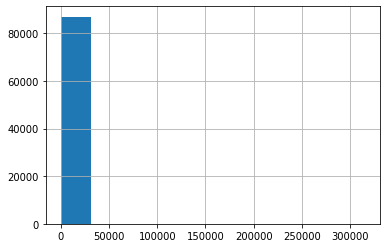

In [ ]:
FIRE_SIZE = numerical["FIRE_SIZE"]
FIRE_SIZE.hist()

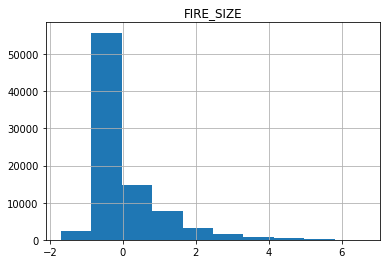

Response Minimum: FIRE_SIZE   -1.698422
dtype: float64
Response Maximum: FIRE_SIZE    6.638909
dtype: float64
Linear Regression Coefficients: [[ 1.03704077e+08 -1.03704077e+08  1.47492378e+10 -1.47492378e+10
  -3.64134423e-02  1.77510045e-02 -2.09909761e+10  2.09909761e+10
   3.66966471e-01 -5.58446348e-03  2.70166660e+10 -2.70166660e+10
  -1.42716001e+10  1.42716001e+10 -1.72787955e+10  1.72787955e+10
  -1.78996530e+10  1.78996530e+10  5.89141995e-02  1.57028880e+10
  -1.57028880e+10 -3.12987808e-02 -9.36800763e-02 -2.84259652e-01
  -8.77977069e-03  3.94475441e+09 -3.94475441e+09 -6.43242757e+09
   6.43242757e+09  4.95082214e-02  7.37310301e+10 -7.37310301e+10
  -1.06289991e+09  1.06289990e+09  7.54375549e+09 -7.54375549e+09
   3.59283332e+09 -3.59283332e+09 -1.90976778e+07  1.90976777e+07
   3.10789346e+09 -3.10789346e+09  1.30289919e+08 -1.30289920e+08
   3.96357816e+08 -3.96357816e+08 -8.76759070e+09  8.76759070e+09
   4.60180044e-02  2.22729209e+08 -2.22729209e+08  1.47006300e+09


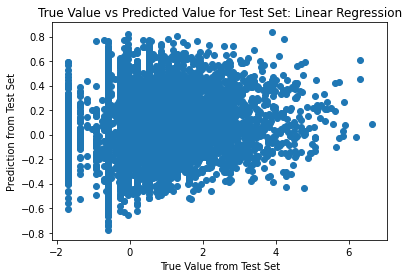

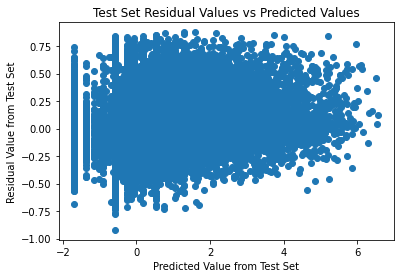

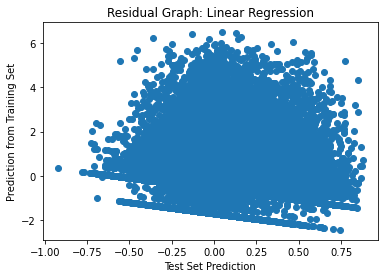

Response Minimum: FIRE_SIZE   -1.698422
dtype: float64
Response Maximum: FIRE_SIZE    6.638909
dtype: float64
Ridge Regression Coefficients: [[ 4.33594698e-02  4.33594698e-02  1.03918029e-01  1.03918029e-01
  -3.55139592e-02  1.94372343e-02 -2.37730649e-03 -2.37730649e-03
   2.95197670e-01 -5.50421501e-03 -1.64275460e-02 -1.64275460e-02
   2.09743454e-02  2.09743454e-02 -2.73514574e-03 -2.73514574e-03
  -2.32735103e-01 -2.32735103e-01  5.67128831e-02  1.03293300e-01
   1.03293300e-01 -3.10742784e-02 -9.37498845e-02 -1.59790510e-01
  -8.65886988e-03 -2.02195149e-03 -2.02195149e-03  1.63489531e-01
   1.63489531e-01  4.85216754e-02 -7.13064955e-03 -7.13064954e-03
  -1.53354316e-01 -1.53354316e-01 -1.89397625e-03 -1.89397625e-03
   1.25155780e-01  1.25155780e-01 -3.62207874e-02 -3.62207874e-02
   3.87649977e-02  3.87649977e-02 -2.95336422e-01 -2.95336422e-01
  -7.49515622e-03 -7.49515622e-03 -1.50014523e-02 -1.50014523e-02
   4.71990775e-02  1.57950987e-02  1.57950987e-02  3.95388936e-02
 

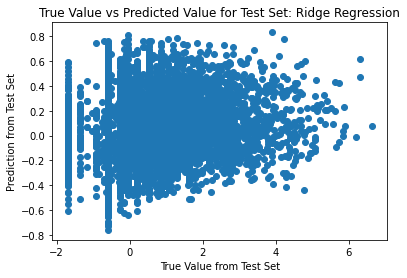

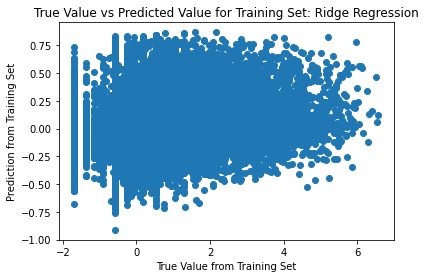

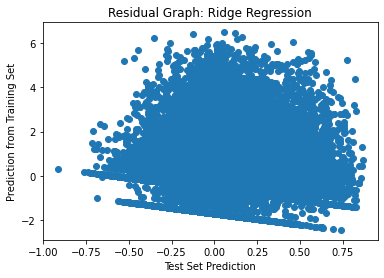

In [ ]:
log_fire_size = pd.DataFrame(np.log(FIRE_SIZE))
log_fire_size = log_fire_size.replace([np.inf, -np.inf], np.nan)
log_fire_size = log_fire_size.fillna(0)
log_fire_size = (log_fire_size - log_fire_size.mean()) / log_fire_size.std()
log_fire_size.hist()
plt.show()

run_full_linear_regression_with_accuracy(fire_size_prediction_df[:SUBSET], log_fire_size[:SUBSET])
run_full_ridge_regression_with_accuracy(fire_size_prediction_df[:SUBSET], log_fire_size[:SUBSET])

### Basic Neural Network Model

In [ ]:
import tensorflow as tf

In [ ]:
log_fire_size = pd.DataFrame(np.log(FIRE_SIZE))
log_fire_size = log_fire_size.replace([np.inf, -np.inf], np.nan)
log_fire_size = log_fire_size.fillna(0)
log_fire_size = (log_fire_size - log_fire_size.mean()) / log_fire_size.std()

X_train, X_test, y_train, y_test = train_test_split(fire_size_prediction_df, log_fire_size, test_size=0.2, random_state=2020)

(69684, 231)
Epoch 1/300
2178/2178 [==============================] - 10s 4ms/step - loss: 0.9930 - mean_squared_error: 0.9930 - mean_absolute_error: 0.7215
Epoch 2/300
2178/2178 [==============================] - 8s 4ms/step - loss: 0.9731 - mean_squared_error: 0.9731 - mean_absolute_error: 0.7130
Epoch 3/300
2178/2178 [==============================] - 8s 4ms/step - loss: 0.9692 - mean_squared_error: 0.9692 - mean_absolute_error: 0.7113
Epoch 4/300
2178/2178 [==============================] - 8s 4ms/step - loss: 0.9647 - mean_squared_error: 0.9647 - mean_absolute_error: 0.7087
Epoch 5/300
2178/2178 [==============================] - 8s 4ms/step - loss: 0.9621 - mean_squared_error: 0.9621 - mean_absolute_error: 0.7080
Epoch 6/300
2178/2178 [==============================] - 8s 3ms/step - loss: 0.9584 - mean_squared_error: 0.9584 - mean_absolute_error: 0.7058
Epoch 7/300
2178/2178 [==============================] - 8s 4ms/step - loss: 0.9554 - mean_squared_error: 0.9554 - mean_absolute

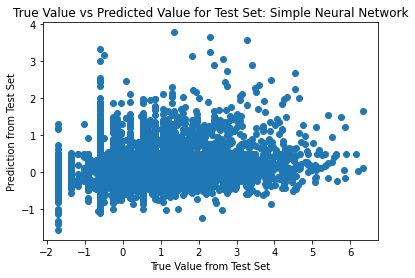

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_140 (Dense)           (None, 231)               53592     
                                                                 
 dropout_42 (Dropout)        (None, 231)               0         
                                                                 
 dense_141 (Dense)           (None, 231)               53592     
                                                                 
 dense_142 (Dense)           (None, 231)               53592     
                                                                 
 dense_143 (Dense)           (None, 1)                 232       
                                                                 
Total params: 161,008
Trainable params: 161,008
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
print(X_train.shape)


model = tf.keras.models.Sequential([Dense(231, activation="relu"),
                                    Dropout(0.2),
                                    Dense(231, activation="relu"),
                                    Dense(231, activation="relu"),
                                    Dense(1)])

loss_function = MeanSquaredError()
model.compile(optimizer="adam", loss=loss_function, metrics=["mean_squared_error", "mean_absolute_error"])
model.fit(X_train, y_train, epochs = 300)
model.evaluate(X_test, y_test, verbose=2)


test_predictions = model.predict(X_test)
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.set_xlabel("True Value from Test Set")
ax1.set_ylabel('Prediction from Test Set')
ax1.set_title('True Value vs Predicted Value for Test Set: Simple Neural Network')
ax1.scatter(y_test, test_predictions)
plt.show()

print(model.summary())

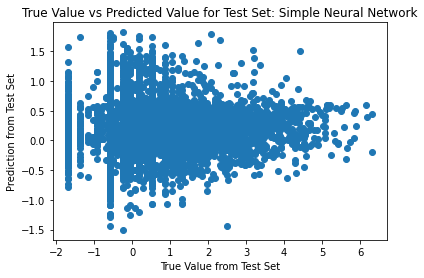

545/545 - 1s - loss: 1.1828 - mean_squared_error: 1.1828 - mean_absolute_error: 0.8530 - 816ms/epoch - 1ms/step


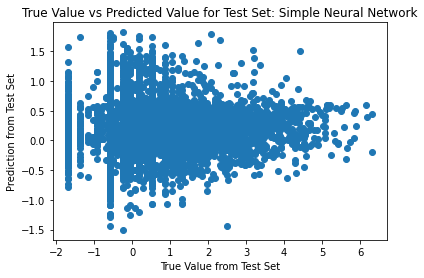

In [ ]:
# 60 epochs, 231, 50, 50, 50 ,50 
model.evaluate(X_test, y_test, verbose=2)

test_predictions = model.predict(X_test)

fig = plt.figure()
ax1 = fig.add_subplot()
ax1.set_xlabel("True Value from Test Set")
ax1.set_ylabel('Prediction from Test Set')
ax1.set_title('True Value vs Predicted Value for Test Set: Simple Neural Network')
ax1.scatter(y_test, test_predictions)
plt.show()

545/545 - 1s - loss: 1.1828 - mean_squared_error: 1.1828 - mean_absolute_error: 0.8530 - 824ms/epoch - 2ms/step


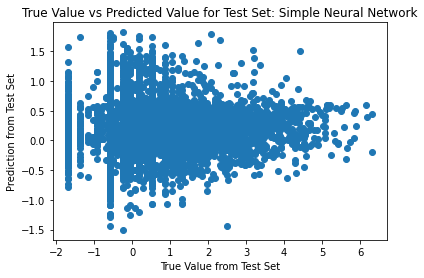

In [ ]:
model.evaluate(X_test, y_test, verbose=2)

test_predictions = model.predict(X_test)

fig = plt.figure()
ax1 = fig.add_subplot()
ax1.set_xlabel("True Value from Test Set")
ax1.set_ylabel('Prediction from Test Set')
ax1.set_title('True Value vs Predicted Value for Test Set: Simple Neural Network')
ax1.scatter(y_test, test_predictions)
plt.show()

545/545 - 1s - loss: 1.1828 - mean_squared_error: 1.1828 - mean_absolute_error: 0.8530 - 881ms/epoch - 2ms/step


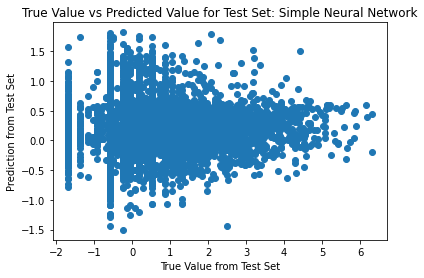

In [ ]:
# model = tf.keras.models.Sequential([Dense(231, activation="relu"),
#                                     Dropout(0.2),
#                                     Dense(50, activation="relu"),
#                                     Dense(25, activation="relu"),
#                                     Dense(1)])

model.evaluate(X_test, y_test, verbose=2)

test_predictions = model.predict(X_test)

fig = plt.figure()
ax1 = fig.add_subplot()
ax1.set_xlabel("True Value from Test Set")
ax1.set_ylabel('Prediction from Test Set')
ax1.set_title('True Value vs Predicted Value for Test Set: Simple Neural Network')
ax1.scatter(y_test, test_predictions)
plt.show()

545/545 - 1s - loss: 1.1828 - mean_squared_error: 1.1828 - mean_absolute_error: 0.8530 - 783ms/epoch - 1ms/step


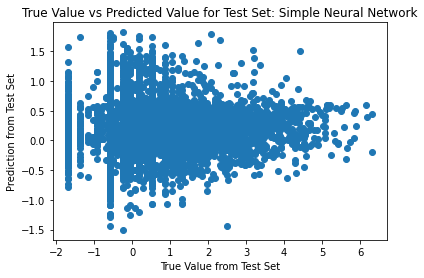

In [ ]:
# model = tf.keras.models.Sequential([Dense(231, activation="relu"),
#                                     Dropout(0.2),
#                                     Dense(50, activation="relu"),
#                                     Dense(25, activation="relu"),
#                                     Dense(1)])

# loss_function = MeanSquaredError()
# model.compile(optimizer="adam", loss=loss_function, metrics=["mean_squared_error", "mean_absolute_error"])
# model.fit(X_train, y_train, epochs = 1000)

model.evaluate(X_test, y_test, verbose=2)

test_predictions = model.predict(X_test)

fig = plt.figure()
ax1 = fig.add_subplot()
ax1.set_xlabel("True Value from Test Set")
ax1.set_ylabel('Prediction from Test Set')
ax1.set_title('True Value vs Predicted Value for Test Set: Simple Neural Network')
ax1.scatter(y_test, test_predictions)
plt.show()

# Neural Network Classifier

First, we want to remove the status cause code from out dataframe, and convert it to a one-hot encoding.

In [ ]:

# cleaned.info(verbose=True)
cause_codes = cleaned["STAT_CAUSE_CODE"]

features = primary_station_df.copy()

if "STAT_CAUSE_CODE" in features:
  del features["STAT_CAUSE_CODE"]
if "STAT_CAUSE_DESCR" in features:
  del features["STAT_CAUSE_DESCR"]

# encoder = OneHotEncoder()
# cause_codes = np.array(cause_codes)
# cause_codes = cause_codes.reshape(-1, 1)
# cause_codes_encoded = encoder.fit_transform(cause_codes).toarray() * 1.0
# print(cause_codes_encoded)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.losses import SparseCategoricalCrossentropy

def run_full_classification_neural_net(features, predictors, epochs = 10, model=None):
  X_train, X_test, y_train, y_test = train_test_split(np.array(X), Y, test_size=0.2, random_state=2020)
  # Classification into 12 different fire cause code classes.
  if model is None:
    model = tf.keras.models.Sequential([Dense(233, activation="relu"),
                                      Dense(25, activation="relu"),
                                      Dropout(0.2),
                                      Dense(25, activation="relu"),
                                      Dense(25, activation="relu"),
                                      Dense(14, activation="relu")])
  

  # Make a quick untrained prediction
  predictions = model(X_train[:1]).numpy()
  print(predictions)
  print(tf.nn.softmax(predictions).numpy()) # Probability of each class

  loss_function = SparseCategoricalCrossentropy(from_logits=True)
  model.compile(optimizer="adam", loss=loss_function, metrics=["accuracy"])
  print(model.summary())
  model.fit(X_train, y_train, epochs = epochs)
  print("EVALUATION:")
  print(model.evaluate(X_test, y_test))


In [ ]:
# These are the variables to learn against
X = features
Y = cause_codes

run_full_classification_neural_net(X, Y, epochs = 200)

[[0.48183015 0.53273875 0.         1.0898234  0.14692128 0.
  0.         0.35303557 0.54752827 0.18044797 0.2152055  0.1799257
  0.13928226 0.00763759]]
[[0.08345924 0.08781805 0.05154876 0.15329307 0.05970702 0.05154876
  0.05154876 0.07337357 0.08912648 0.06174273 0.06392648 0.06171049
  0.05925265 0.05194398]]
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_65 (Dense)            (1, 233)                  54522     
                                                                 
 dense_66 (Dense)            (1, 400)                  93600     
                                                                 
 dropout_11 (Dropout)        (1, 400)                  0         
                                                                 
 dense_67 (Dense)            (1, 400)                  160400    
                                                                 
 d

Next, we will try to train and test ignoring fires that have unknown cause.

In [ ]:
cause_codes = cleaned["STAT_CAUSE_CODE"]
features = primary_station_df.copy()

known_cause_index = (cause_codes != 9) & (cause_codes != 13)

known_cause_codes = cause_codes[known_cause_index]
known_features = features[known_cause_index]

run_full_classification_neural_net(known_features, known_cause_codes, epochs = 100)

[[0.29975367 0.38708732 0.         0.15639737 0.19750558 0.4500361
  0.64230233 0.61549467 0.7704089  0.         0.         0.
  0.6867556  0.        ]]
[[0.06858199 0.07484083 0.0508193  0.05942254 0.06191619 0.07970341
  0.09659999 0.09404477 0.10980271 0.0508193  0.0508193  0.0508193
  0.10099105 0.0508193 ]]
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (1, 233)                  54522     
                                                                 
 dense_97 (Dense)            (1, 25)                   5850      
                                                                 
 dropout_30 (Dropout)        (1, 25)                   0         
                                                                 
 dense_98 (Dense)            (1, 25)                   650       
                                                                 
 de

In [ ]:
# trying a more complex architecture
model = tf.keras.models.Sequential([Dense(233, activation="relu"),
                                      Dense(233, activation="relu"),
                                      Dropout(0.1),
                                      Dense(233, activation="relu"),
                                      Dropout(0.2),
                                      Dense(14, activation="relu")])
run_full_classification_neural_net(known_features, known_cause_codes, epochs = 400, model=model)

[[0.         0.6354657  0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.33310336
  0.         0.        ]]
[[0.06543136 0.12352794 0.06543136 0.06543136 0.06543136 0.06543136
  0.06543136 0.06543136 0.06543136 0.06543136 0.06543136 0.09129582
  0.06543136 0.06543136]]
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_116 (Dense)           (1, 233)                  54522     
                                                                 
 dense_117 (Dense)           (1, 233)                  54522     
                                                                 
 dropout_35 (Dropout)        (1, 233)                  0         
                                                                 
 dense_118 (Dense)           (1, 233)                  54522     
                                                                 
 

In [ ]:
# probability_model = tf.keras.Sequential([
#   model,
#   tf.keras.layers.Softmax()
# ])

In [ ]:
# probability_model(X_test[:5])

<tf.Tensor: shape=(5, 14), dtype=float32, numpy=
array([[3.29549704e-03, 1.66717973e-02, 2.67233163e-01, 3.45799029e-02,
        4.54233326e-02, 6.08601756e-02, 3.29549704e-03, 9.02992263e-02,
        4.02569845e-02, 3.03870469e-01, 3.29549704e-03, 5.01898900e-02,
        3.29549704e-03, 7.74330422e-02],
       [6.72030510e-05, 9.49687421e-01, 8.00500251e-03, 3.49900965e-03,
        7.98075087e-03, 2.22626817e-03, 6.72030510e-05, 2.14828923e-03,
        1.18853315e-03, 2.42914725e-02, 6.72030510e-05, 6.72030510e-05,
        6.72030510e-05, 6.37105783e-04],
       [1.72957755e-03, 1.41575588e-02, 1.70311946e-02, 1.72957755e-03,
        5.11530787e-02, 8.17846507e-02, 1.72957755e-03, 7.08773196e-01,
        7.14560365e-03, 9.76177081e-02, 1.72957755e-03, 1.72957755e-03,
        1.72957755e-03, 1.19594922e-02],
       [7.89784535e-04, 5.61121881e-01, 4.12679575e-02, 3.99304330e-02,
        1.66325241e-01, 1.64578483e-02, 7.89784535e-04, 1.33630764e-02,
        1.30247315e-02, 1.40769288e-